# WEC Recs Submission - Fakeddit multi-modal fakenews detection model

- Name: Pranav Bhat
- Roll no: 231IT049

***

## Problem Statement 

The main aim of developing this AI model is to create an efficient data-preprocessing pipeline to feed data and train the model on multi-modal data, namely text and images. Using the dataset, the model must be able to label the text-image input pairs into several categories outlined inside the dataset.

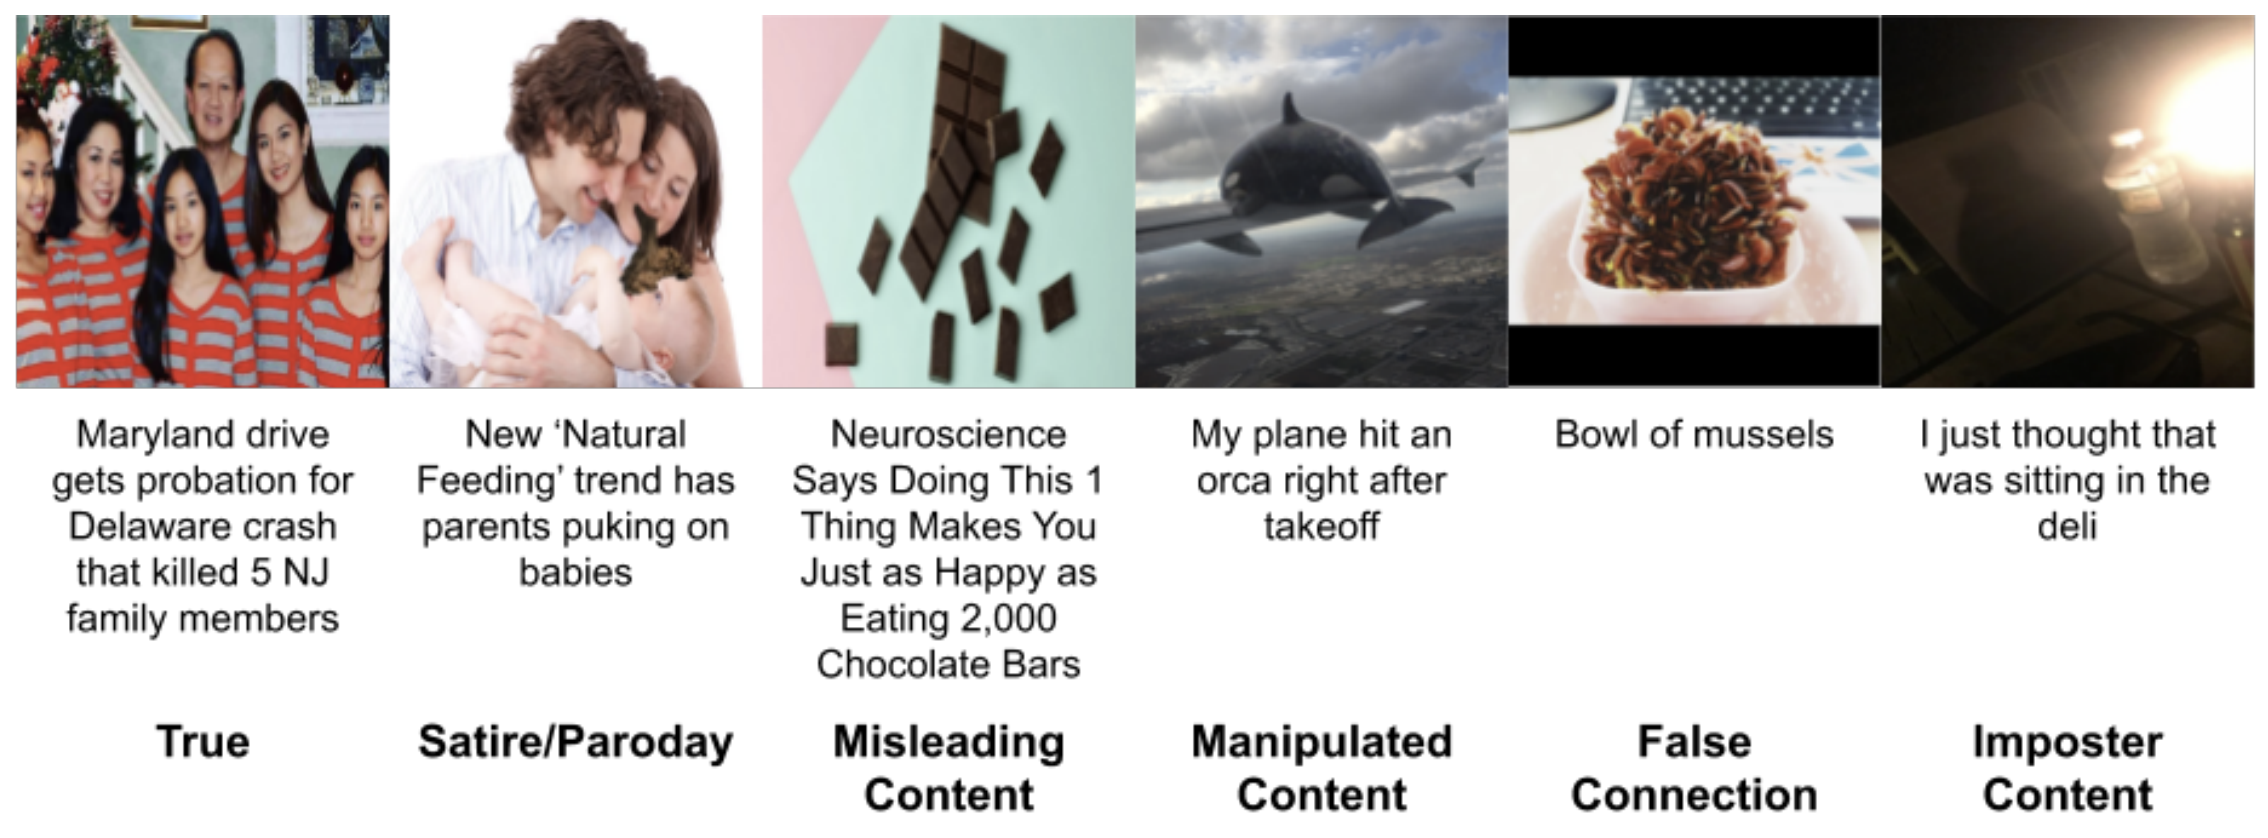

## Using the dataset

Since the main objective of this notebook is to establish a pipeline capable of accepting text and image inputs and generate an output label, we will not be using the primary dataset(sized at 106GB). Rather we will be accessing all the images and text as features in a .tsv file provided on the [GitHub repo](https://github.com/entitize/Fakeddit).

## Plan of action

I plan to go ahead with using pyTorch to develop a model for this task.

I plan to take two approaches separately:

1. Using DeBERTa and Visual Transformer as text and image models separately.
2. Altering the initial approach with a better fusion mechanism.

## Code

### Imports

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
import os
from io import BytesIO
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import VisualBertModel, VisualBertConfig, BertTokenizer
from transformers import DebertaTokenizer, DebertaModel, ViTModel, ViTFeatureExtractor
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

2024-08-12 16:01:38.207258: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 16:01:38.207384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 16:01:38.355716: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Obtaining the data

I have taken the dataset from this link. It contains .tsv files with text and images.

In [10]:
df = pd.read_csv('/kaggle/input/fakeedit-dataset/fakedit-dataset/multimodal_train.tsv',sep = '\t')

In [11]:
df.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,My Walgreens offbrand Mucinex was engraved wit...,0.84,1,0,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,This concerned sink with a tiny hat,0.99,0,2,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,Hackers leak emails from UAE ambassador to US,0.92,1,0,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,PsBattle: Puppy taking in the view,0.95,1,0,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,I found a face in my sheet music too!,0.84,0,2,2


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564000 entries, 0 to 563999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   author                535290 non-null  object 
 1   clean_title           564000 non-null  object 
 2   created_utc           564000 non-null  float64
 3   domain                396143 non-null  object 
 4   hasImage              564000 non-null  bool   
 5   id                    564000 non-null  object 
 6   image_url             562466 non-null  object 
 7   linked_submission_id  167857 non-null  object 
 8   num_comments          396143 non-null  float64
 9   score                 564000 non-null  int64  
 10  subreddit             564000 non-null  object 
 11  title                 564000 non-null  object 
 12  upvote_ratio          396143 non-null  float64
 13  2_way_label           564000 non-null  int64  
 14  3_way_label           564000 non-null  int64  
 15  

The challenge also outlines that only '6_way_label' and 'clean_title', along with the images are the only columns to be utilised in training a model.

My first aim is to structure the dataset to include only the required columns. I'm following a 80:20 train-test split on the model.

In [14]:
train_df = df[['clean_title', 'image_url', '6_way_label']].copy()

# Drop rows with missing values
train_df = train_df.dropna()

# I am splitting data here with 80-20 split.
train_data, valid_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Reset indices for both sets
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)


My approach to creating a pipeline for handling multi-modal inputs involvingc creating a class for the dataset. The class uses a dunder method for getting the text and images and returns the attention masks, ids, the pixel values of the image and the label.

In [15]:
class MultiModalDataset(Dataset):
    def __init__(self, dataframe, transform, tokenizer, feature_extractor, text_column, image_column, label_column):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.transform = transform
        self.feature_extractor = feature_extractor
        self.text_column = text_column
        self.image_column = image_column
        self.label_column = label_column
        
    def __len__(self):
        return len(self.dataframe)
        
    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx][self.text_column]
        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=128
        ) #tokenising the text
        image_url = self.dataframe.iloc[idx][self.image_column]
        image = self.download_image(image_url) #I used the requests library to download the image from the URL given in the dataset.
        
        if self.transform:
            image = self.transform(image) #applies a transformer to uniformly resize the images, check the implementation I've used in a later cell.
        
        image_inputs = self.feature_extractor(images=image, return_tensors='pt') #extract features from the images.
        pixel_values = image_inputs['pixel_values'].squeeze(0) #takes the pixel_values and squeeze the image to a smaller size.
        
        label = self.dataframe.iloc[idx][self.label_column] # takes the 6-way labels from the column.
        
        #returns a dictionary with the necessary inputs to setup a multi-modal dataset.
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'pixel_values': pixel_values,
            'label': torch.tensor(label, dtype=torch.long)
        }
    
    def download_image(self, url):
        try:
            response = requests.get(url) #since the images are present as urls.
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert("RGB")
            return img
        except Exception as e:
            print(f"Error downloading image from {url}: {e}")
            return Image.new("RGB", (224, 224))  # Return a blank image if there's an error


$ normalizedpixel = (pixelvalue-mean)/std $

The formula for the image transformation step

### Data Preprocessing

Since there are around 564000 samples in the dataset, I don't think that data augmentation is a necessity. Rather we could use steps such as a normalization of the images and dropping of rows missing data, as additional steps.

### Building the model (Approach 1)

For making this model, I have taken inspiration from this [notebook](https://www.kaggle.com/code/fabraz/image-and-text-multimodal#Building-a-Multimodal-Multilabel-Classifier-with-Vision-Transformer-and-DeBERTa). It makes use of the ViT(Vision Transformer) and the DeBERTa model to deal with images and text(with attention mechanisms) respectively.

Here's the hugging-face page for the models used:

- ViT: [Click here](https://huggingface.co/docs/transformers/v4.44.0/en/model_doc/vit)
- DeBERTa: [Click here](https://huggingface.co/docs/transformers/v4.44.0/en/model_doc/deberta)

The multi-modal dataset requires several steps of pre-processing to make it usable. Now, after the dataset is ready it's time to focus on the model. The model comprises of two transformers. After they are loaded, a fully connected layer is used to reduce the dimenstionality from the 'hidden_size' to 256 dimensions. We then create a sequential model for a feed-forward network.

Next we implement the "forward" function. The function takes in the input_ids of tokenized text, the attention mask and the pixel values of the image. Now let's breakdown the necessity of these three in the model:

- input_ids: The input_ids represent the tokenised text IDs produced by the DeBERTa tokeniser.
- attention_mask: Represents the attention_mask of the text inputs, for the tokens. The masks are binary in nature. 1s for the [SEP] tokens, [CLS] tokens, and the words themselves. 0s for the padding.
- pixel_values: Processed pixels values for the images.

After the DeBERTa model receives the input_ids, it generates contextual embeddings (using its transformer architecture via self-attention, feed-forward networks etc). The <code>text_outputs</code> tensor contains a tensor 'last_hidden_state', for all the embeddings. So, in the end, we basically use 
<code>text_outputs.last_hidden_state[:,0,:]</code>, to select the embedding of the '[CLS]' token for each sequence in a batch. It then passes these embeddings through a fully connected layer which transforms the embeddings from the 'hidden_layer' size of the DeBERTa model, down to 256 size.

Here's a image of the DeBERTa model architecture:
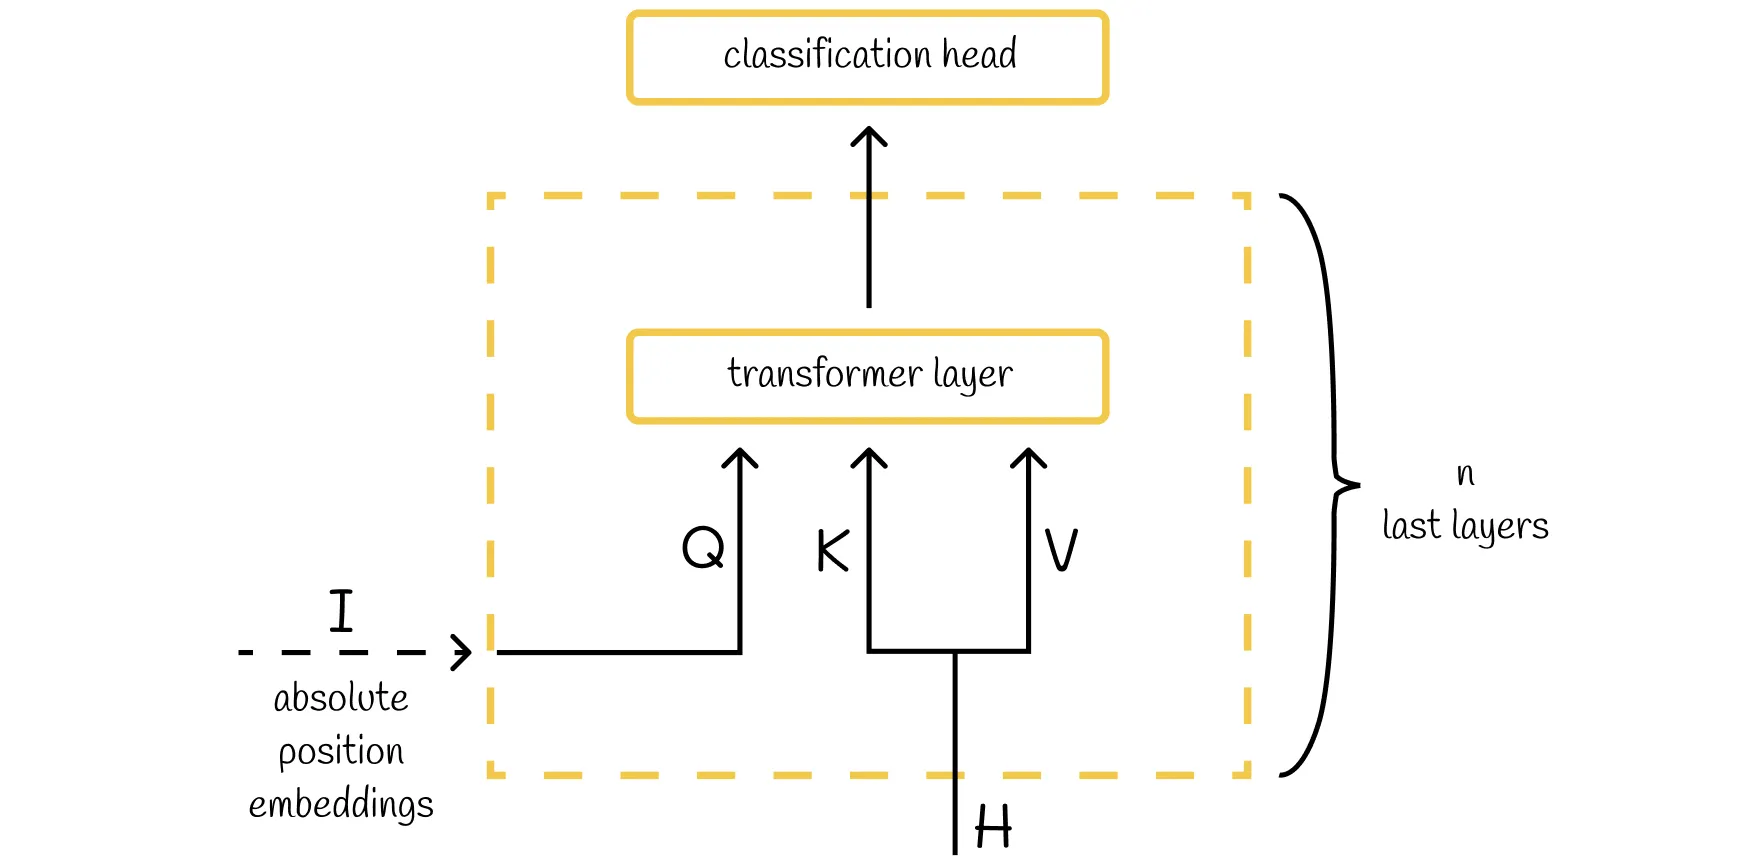


Now, in a similar fashion, the same process is run for images. The ViT model accepts a tensor containing pixel values of the image. Inside the ViT model, it breaks down the image to fixed size-patches(of 16x16). The patches are flattened and linearly embedded to create patch embeddings. Each patch has an associated position embedding to trace its relative position. The combined patch and position embeddings are fed through multiple layers of transformers which then gives the tensor <code>image_outputs</code>. The [CLS] token embedding is selected and is passed into the fully connected layer to bring down the dimensions from "hidden_size" to 256.

In the next step, the fusion mechanism is implemented. Here, concatenation, which is an example of early fusion, is the fusion mechanism that I've chosen, because of its simplicity. It concatenates embeddings from both image and text and finally passes it through the classifier network. The generated logits are returned by the model, and this marks the completion of a forward pass. One disadvantage of this mechanism of fusion is the higher dimensionality which it introduces, which leads to overfitting and sensitivity of outliers.


Here's the ViT model architecture:

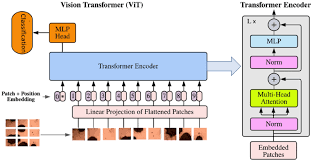

In [16]:
class MultiModalFakeNewsDetector1(nn.Module):
    def __init__(self, text_model='microsoft/deberta-base', image_model = 'google/vit-base-patch16-224', num_classes = 6):
        super(MultiModalFakeNewsDetector,self).__init__()
        
        self.text_model = DebertaModel.from_pretrained(text_model)
        self.image_model = ViTModel.from_pretrained(image_model)
    
        #For now I will stick to fully-connected layers
        self.text_fc = nn.Linear(self.text_model.config.hidden_size,256)
        self.image_fc = nn.Linear(self.image_model.config.hidden_size, 256)
    
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(512, num_classes) # later, the softmax function needs to be used to extract individual probabalities for 6 classes.
        )
    
    def forward(self, input_ids, attention_mask, pixel_values): #Forward pass
        text_outputs = self.text_model(input_ids=inputs_ids, attention_mask=attention_mask)
        text_embedding = self.text_fc(text_outputs.last_hidden_state[:,0,:])
        
        image_outputs = self.image_model(pixel_values=pixel_values)
        image_embedding = self.image_fc(image_outputs.last_hidden_state[:,0,:])
        
        combined_embedding = torch.cat((text_embedding, image_embedding), dim=1)
        
        logits = self.classifier(combined_embedding)
        
        return logits

### Building a model (Approach 2)

The only difference on this model is the attention mechanism being used. Since the attention mechanism is a very crucial part of ensuring the success of the model, I've decided to implement a better version of the first model. I've implemented this from scratch after reading up about it.

This is where I bring in multi-head attention. The reason why I've chosen multi-head attention here is its contextual capabilites. Especially in cases like fake news detection, there may be several cases where the textual input might provide more context than the image or vice versa. This contextual relevance in lacking in methods like early fusion which simply combine the embeddings. Also multi-head attention computes mulitple attention processes in parallel, known as 'heads'.

Each input element is transformed into three different representations namely query,key and value.

- Query: Here we use the text embeddings as the query. This is because the text here behaves as the modality which seeks to match the context within itself to an image, and hence it behaves literally like a 'query'. That is my understanding, as I see it.

- Key: Keys here are taken as the image embeddings. The image embeddings are what the text embeddings actually point towards for context. 

- Value: I again use the image embeddings as they themselves are the final outputs which contain all the context between the image and the text.

This introduces cross-modal attention and performs a similar job to concatenating embeddings, just that this is on much deeper and more efficient manner.

In [17]:
class MultiModalFakeNewsDetector2(nn.Module):
    def __init__(self, text_model='microsoft/deberta-base', image_model='google/vit-base-patch16-224', num_classes=6):
        super(MultiModalFakeNewsDetector, self).__init__()

        self.text_model = DebertaModel.from_pretrained(text_model)
        self.image_model = ViTModel.from_pretrained(image_model)

        # Fullyconnected layers for dimensionality reduction and transformation
        self.text_fc = nn.Linear(self.text_model.config.hidden_size, 256)
        self.image_fc = nn.Linear(self.image_model.config.hidden_size, 256)

        # Multihead attention is being implemented here.
        self.attention = nn.MultiheadAttention(embed_dim=256, num_heads=8)
        
        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Linear(256, num_classes)  # in the eariler model, there were 512 dimensions. Now, we include only half thanks to the presence of the multi-head attention.
        )

    def forward(self, input_ids, attention_mask, pixel_values):
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_embedding = self.text_fc(text_outputs.last_hidden_state[:, 0, :])

        image_outputs = self.image_model(pixel_values=pixel_values)
        image_embedding = self.image_fc(image_outputs.last_hidden_state[:, 0, :])

        # Reshape for attention mechanism (requires 3D input: seq_len, batch_size, embed_dim)
        text_embedding = text_embedding.unsqueeze(0)  # Now the shape is basically -> [1, batch_size, embed_dim]
        image_embedding = image_embedding.unsqueeze(0) 

        # Query is text embedding, key and value are image embedding
        attended_output, _ = self.attention(text_embedding, image_embedding, image_embedding)
        attended_output = attended_output.squeeze(0)  # Shape: [batch_size, embed_dim]

        # Classification
        logits = self.classifier(attended_output)

        return logits

### Training the model

Now that we have found ways to structure the dataset and have a working model for multi-modal inputs, we can go ahead with the training step. The training function takes in a dataloader, criterion for evaluating a model and the device on which the inputs will be stored.

In [18]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0  #Tracking the total loss for the epoch
    correct_predictions = 0  # Track the number of correct predictions

    # Iterates over each batch of data from the dataloader
    for batch in dataloader:
        # Moving the input data and labels to the specified device (GPU or CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)
        #Reset gradients for the optimizer on each run
        optimizer.zero_grad()

        # Perform a forward pass through the model to get outputs
        outputs = model(input_ids, attention_mask, pixel_values)

        #Compute the loss between the model outputs and true labels
        loss = criterion(outputs, labels)

        # Perform backpropagation to compute gradients
        loss.backward()
        # Update model parameters using the optimizer, step by step.
        optimizer.step()

        #Accumulate the loss over each batch of input...
        running_loss += loss.item() * input_ids.size(0)

        # Get the predicted class by finding the index with the highest score
        _, preds = torch.max(outputs, dim=1)
        # Count the number of correct predictions in this batch
        correct_predictions += torch.sum(preds == labels)

    #Calculate the accuracy 
    epoch_acc = correct_predictions.double() / len(dataloader.dataset)

    # Return the average loss and accuracy for this epoch
    return epoch_loss, epoch_acc


Below we implement the function which evaluates the model on each run. It has a similar implementation as the train_model function.

In [19]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0 
    correct_predictions = 0  
    with torch.no_grad():
        # Iterattion
        for batch in dataloader:
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask, pixel_values)

            loss = criterion(outputs, labels)
            running_loss += loss.item() * input_ids.size(0)
            _, preds = torch.max(outputs, dim=1)

            correct_predictions += torch.sum(preds == labels)

    # Average losses
    epoch_loss = running_loss / len(dataloader.dataset)

    epoch_acc = correct_predictions.double() / len(dataloader.dataset)

    # Return the average loss and accuracy for this evaluation
    return epoch_loss, epoch_acc


Now let us model all the required data into a multimodal dataset and then train the model on that data.

### Modeling

In [20]:
# Setting up some variables
IMAGE_SIZE = 224
NUM_EPOCHS = 10
LEARNING_RATE=0.001
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
#Meant for image transformation. Its normalises the image using tested metrics obtained from the ImageNet dataset.

tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std = [0.229, 0.224, 0.225]) # these statistics are based from those on which the torchvision library was trained(i.e ImageNet)
]) 

We can now setup the dataset for training and validation on the data.

In [22]:
#text tokeniser
text_tokenizer = DebertaTokenizer.from_pretrained("microsoft/deberta-base")

#image feature extractor
image_feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

#generates dataset to train the model
train_dataset = MultiModalDataset(train_data, tfms, image_feature_extractor, text_tokenizer, 'clean_title','image_url','6_way_label')
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)

#generates dataset for validation.
val_dataset = MultiModalDataset(valid_data, tfms, image_feature_extractor, text_tokenizer, 'clean_title', 'image_url', '6_way_label')
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=True)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


### Initialising the model

In [23]:
model = MultiModalFakeNewsDetector2().to(DEVICE)
print(model)

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MultiModalFakeNewsDetector(
  (text_model): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (int

In [24]:
#setting the criterion
criterion = nn.CrossEntropyLoss() #CrossEntropyLoss internally applies the softmax function.
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE) #uses AdamW as the optimizer function. 
# It is an improved version of the Adam optimizer. We also pass in the model parameters in order to specify the paramaters to be tuned during the model run.

In [ ]:
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = evaluate_model(model, val_loader, criterion, DEVICE)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")